# DeepDream with Inception V3 Model

####Preparations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/deep_dream/'
sys.path.append(BASE_PATH)

In [0]:
import numpy as np
import pandas as pd
from IPython.display import display

from colabio import ColabIO
io = ColabIO(BASE_PATH)

from datetime import datetime
%load_ext tensorboard
import tensorflow as tf
import tensorboard

###Image Processing

In [0]:
def preprocess(image):
  ''' The model was trained on normalized images.
  image     --  np.ndarray

  returns   --  tf.Tensor
  '''
  img = tf.keras.applications.inception_v3.preprocess_input(image)
  return tf.convert_to_tensor(img, dtype=tf.float32)

def deprocess(image):
  img = 255*(image + 1.0)/2.0
  return tf.cast(img, tf.uint8).numpy()

def gaussian_filter(image, kernel_size=11, sigma=5.0):
  '''
  input         -- tf.Tensor
  kernel_size   -- tf.int32
  sigma         -- tf.float32

  returns       -- tf.Tensor
  '''
  def gauss_kernel(channels, kernel_size, sigma):
    ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
    xx, yy = tf.meshgrid(ax, ax)
    kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
    kernel = kernel / tf.reduce_sum(kernel)
    kernel = tf.expand_dims(kernel, axis=-1)
    kernel = tf.tile(kernel, [1, 1, channels])
    return kernel

  gaussian_kernel = gauss_kernel(tf.shape(image)[-1], kernel_size, sigma)
  gaussian_kernel = tf.expand_dims(gaussian_kernel, axis=-1)

  try:
    blurred = tf.nn.depthwise_conv2d(input=image, filter=gaussian_kernel, strides=[1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
  except:
    img_batch = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(input=img_batch, filter=gaussian_kernel, strides=[1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
  return tf.squeeze(blurred)

## future
def random_roll(image, maxroll):
  ''' To avoid tile seams.
  img       -- np.ndarray
  max       -- int

  returns   -- int, int, np.ndarray
  '''
  dx, dy = np.random.randint(low=-maxroll, high=maxroll, size=(2,))
  img_rolled = np.roll(np.roll(image, dy, axis=0), dx, axis=1)
  return dx, dy, img_rolled

def un_roll(image, dx, dy):
  return np.roll(np.roll(image, -dy, axis=0), -dx, axis=1)

## DeepDream Algorithm

In [0]:
def compute_cost(image):
  img = tf.expand_dims(image, axis=0)
  activations = model(img)
  if len(activations) == 1:
    activations = [activations]

  layer_costs=[]
  for a in activations:
    a = tf.math.square(a)
    cost = tf.math.reduce_mean(a)
    layer_costs.append(cost)

  return tf.reduce_sum(layer_costs)

In [0]:
@tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32))
)
def step(image, step_size, i):
  with tf.GradientTape() as g:
    g.watch(image)
    J = compute_cost(image)
  
  grad = g.gradient(J, image)
  
  N = tf.cast(PARAMS['num_iterations'], dtype=tf.float32)
  n = tf.cast(i, dtype=tf.float32)

  sigma =  n * 2.0 / N + 0.25
  grad_1 = gaussian_filter(grad, sigma=sigma)
  grad_2 = gaussian_filter(grad, sigma=sigma*2.0)
  grad_3 = gaussian_filter(grad, sigma=sigma*4.0)

  grad = (grad_1 + grad_2 + grad_3)
  
  step_size_scaled = step_size / (tf.math.reduce_std(grad) + tf.constant(1e-8))
  img = image + grad * step_size_scaled

  return img

In [0]:
def train(image, num_iterations, step_size):
  img = tf.identity(image)
  s = step_size
  ds = step_size/tf.cast(num_iterations, dtype=tf.float32)

  for i in tf.range(num_iterations):
    s -= ds
    img = step(img, s, i)
    
  return tf.clip_by_value(img, -1, 1)

In [0]:
def dream(image, num_iterations=10, octaves=4, scaling=0.7, blend=0.2, step_size=0.01):
  img = tf.identity(image)
  base_shape = tf.convert_to_tensor(image.shape[:-1], dtype=tf.int32)
  float_base_shape = tf.cast(base_shape, dtype=tf.float32)

  if octaves>0:
    img_blurred = gaussian_filter(img, 1.0)
    new_shape = tf.cast(float_base_shape*(scaling), dtype=tf.int32)
    img_scaled = tf.image.resize(img_blurred, new_shape)

    img_result = dream(img_scaled,
                       num_iterations=num_iterations, 
                       octaves=octaves-1, 
                       scaling=scaling, 
                       blend=blend, 
                       step_size=step_size)
  
    img_rescaled = tf.image.resize(img_result, base_shape)
    img = blend * img + (1.0 - blend) * img_rescaled

  img_result = train(img, num_iterations, step_size)
  
  return img_result

In [0]:
def load_model(layer_names, verbose=0):
  full_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
  
  if verbose==1:
    full_layer_list = [layer.name for layer in full_model.layers]
    display(full_layer_list)
  
  layers = [full_model.get_layer(name).output for name in layer_names]
  display(pd.DataFrame({'Output Layers': layer_names}))
  
  return tf.keras.Model(inputs=full_model.input, outputs=layers)

In [0]:
def run(model, filename, params):
  orig_image = io.load_img(filename)
  io.show_img(orig_image)

  orig_image = preprocess(orig_image)

  stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  logdir = 'logs/func/%s' % stamp
  writer = tf.summary.create_file_writer(logdir)


  tf.summary.trace_on(graph=True, profiler=True)
  img = deprocess(dream(image=orig_image, **params))

  with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)


  io.show_img(img)
  io.save_img(img,  filename)

  return img

##Configuration & Model
####Choose image from input directory:

In [12]:
io_dirs = io.get_io_dirs()
display(io.get_io_dirs())

,Input Directory:,Output Directory:
0,kanagawa.jpg,20200515-101531_IMG_1.jpg
1,IMG_3.jpg,20200515-102508_IMG_1.jpg
2,IMG_2.jpg,
3,IMG_1.jpg,


In [13]:
index = 3
FILENAME = io_dirs.iat[index,0]
display("input image: " + FILENAME)

'input image: IMG_1.jpg'

####Load full inception model:

###Choose output layers from list:

In [15]:
layer_names = [
               #'mixed0',
               #'mixed1',
               #'mixed2',
               'mixed3',
               #'mixed4', 
               #'mixed5',
               #'mixed6', 
               'mixed7'#, 
               #'mixed8', 
               #'mixed9', 
               #'mixed10'
               ]
model = load_model(layer_names)

,Output Layers
0,mixed3
1,mixed7


###Choose dreaming parameters:

In [0]:
params = {
    'num_iterations': 10, 
    'octaves': 4, 
    'scaling': 0.7, 
    'blend': 0.2, 
    'step_size': 0.05
    }

PARAMS = dict([(key, tf.convert_to_tensor(val)) for key, val in params.items()])

##Application

input shape:	 (375, 500, 3)
(type, shape):	(<class 'numpy.ndarray'>, (375, 500, 3))


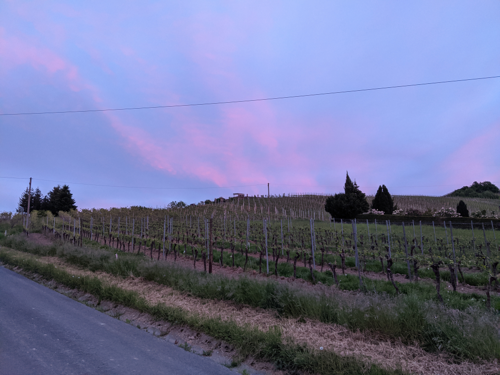

(type, shape):	(<class 'numpy.ndarray'>, (375, 500, 3))


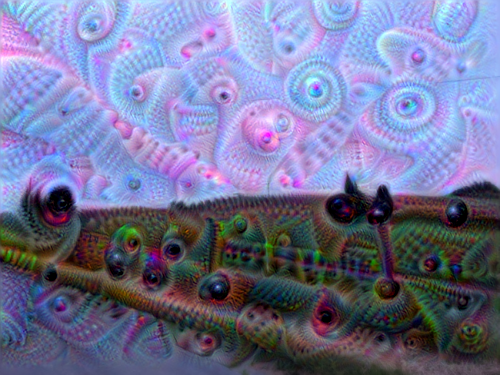

output saved: 20200515-102934_IMG_1.jpg


In [19]:
result = run(model, FILENAME, PARAMS)

In [0]:
%tensorboard --logdir logs/func